In [93]:
import pandas as pd

# EPL 2023/2024 data from Football-Data.co.uk
url = "https://www.football-data.co.uk/mmz4281/2324/E0.csv"

# Load into a DataFrame
df = pd.read_csv(url)

# Preview the data
print(df.head())


  Div        Date   Time     HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  \
0  E0  11/08/2023  20:00      Burnley       Man City     0     3   A     0   
1  E0  12/08/2023  12:30      Arsenal  Nott'm Forest     2     1   H     2   
2  E0  12/08/2023  15:00  Bournemouth       West Ham     1     1   D     0   
3  E0  12/08/2023  15:00     Brighton          Luton     4     1   H     1   
4  E0  12/08/2023  15:00      Everton         Fulham     0     1   A     0   

   HTAG  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  \
0     2  ...     2.28  1.50      1.95      1.98   1.95   1.97      NaN   
1     0  ...     2.63 -2.00      1.95      1.98   1.93   1.97     2.01   
2     0  ...     2.12  0.00      2.02      1.91   2.01   1.92     2.06   
3     0  ...     2.48 -1.75      2.01      1.92   2.00   1.91     2.14   
4     0  ...     1.71 -0.25      2.06      1.87   2.04   1.88     2.08   

   MaxCAHA  AvgCAHH  AvgCAHA  
0      NaN     1.92     1.95  
1     2.09     1.95     

In [94]:
len(df)

380

In [95]:
df_clean = df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'B365H', 'B365D', 'B365A']].copy()
df_clean.dropna(inplace=True)
df_clean.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,11/08/2023,Burnley,Man City,0,3,A,8.00,5.5,1.33
1,12/08/2023,Arsenal,Nott'm Forest,2,1,H,1.18,7.0,15.00
2,12/08/2023,Bournemouth,West Ham,1,1,D,2.70,3.4,2.55
3,12/08/2023,Brighton,Luton,4,1,H,1.33,5.5,9.00
4,12/08/2023,Everton,Fulham,0,1,A,2.20,3.4,3.30


In [96]:
df_clean.loc[:, 'Result'] = df_clean['FTR'].map({'H': 0, 'D': 1, 'A': 2})

In [97]:
X = df_clean[['B365H', 'B365D', 'B365A']]  # Features = bookmaker odds
y = df_clean['Result']                    # Target = match outcome

In [98]:
# Add implied probabilities
df_clean['Imp_H'] = 1 / df_clean['B365H']
df_clean['Imp_D'] = 1 / df_clean['B365D']
df_clean['Imp_A'] = 1 / df_clean['B365A']

# Normalize the probabilities (since bookies bake in margin)
total = df_clean['Imp_H'] + df_clean['Imp_D'] + df_clean['Imp_A']
df_clean['Norm_H'] = df_clean['Imp_H'] / total
df_clean['Norm_D'] = df_clean['Imp_D'] / total
df_clean['Norm_A'] = df_clean['Imp_A'] / total


In [99]:
# Odds Ratios
df_clean['H_A_ratio'] = df_clean['B365H'] / df_clean['B365A']
df_clean['D_A_ratio'] = df_clean['B365D'] / df_clean['B365A']
df_clean['H_D_ratio'] = df_clean['B365H'] / df_clean['B365D']

# Odds Spread: confidence/uncertainty of bookie
df_clean['Odds_Spread'] = df_clean[['B365H', 'B365D', 'B365A']].max(axis=1) - df_clean[['B365H', 'B365D', 'B365A']].min(axis=1)


In [100]:
# Recent form for last 5 games (win rate)
def calculate_recent_form(team, df, n=5):
    recent_games = df[df['HomeTeam'] == team].tail(n)
    win_rate = recent_games['Result'].value_counts(normalize=True).get(0, 0)  # Home team win rate
    return win_rate

# Home/Away win rate
def calculate_home_away_win_rate(team, df):
    home_games = df[df['HomeTeam'] == team]
    away_games = df[df['AwayTeam'] == team]
    
    home_win_rate = home_games[home_games['Result'] == 0].shape[0] / home_games.shape[0]
    away_win_rate = away_games[away_games['Result'] == 2].shape[0] / away_games.shape[0]
    
    return home_win_rate, away_win_rate

# Apply to your dataset (example)
df_clean['HomeWinRate'], df_clean['AwayWinRate'] = zip(*df_clean['HomeTeam'].apply(lambda x: calculate_home_away_win_rate(x, df_clean)))
df_clean['RecentForm'] = df_clean['HomeTeam'].apply(lambda x: calculate_recent_form(x, df_clean))


In [101]:
# Function to calculate recent form win rate
def calculate_recent_form(df, team_col, result_col, team_name, match_index, last_n=3, home=True):
    # Filter matches played by the team before current match
    past_matches = df.iloc[:match_index]
    if home:
        team_matches = past_matches[past_matches['HomeTeam'] == team_name]
        wins = (team_matches['FTR'] == 'H').sum()
    else:
        team_matches = past_matches[past_matches['AwayTeam'] == team_name]
        wins = (team_matches['FTR'] == 'A').sum()
    
    last_matches = team_matches.tail(last_n)
    if last_matches.empty:
        return 0.5  # neutral baseline if no past matches
    win_count = 0
    for _, row in last_matches.iterrows():
        if home and row['FTR'] == 'H':
            win_count += 1
        elif not home and row['FTR'] == 'A':
            win_count += 1
    return win_count / len(last_matches)

# Add recent form columns
home_form = []
away_form = []

for idx, row in df_clean.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    home_form.append(calculate_recent_form(df_clean, 'HomeTeam', 'FTR', home_team, idx, home=True))
    away_form.append(calculate_recent_form(df_clean, 'AwayTeam', 'FTR', away_team, idx, home=False))

df_clean['HomeRecentForm'] = home_form
df_clean['AwayRecentForm'] = away_form


In [102]:
# Function to compute team home/away win rate
def compute_team_stats(df):
    home_win_rates = {}
    away_win_rates = {}

    teams = set(df['HomeTeam']).union(set(df['AwayTeam']))
    for team in teams:
        home_games = df[df['HomeTeam'] == team]
        away_games = df[df['AwayTeam'] == team]

        # Home: result == 0 is a win
        home_win = (home_games['Result'] == 0).sum()
        away_win = (away_games['Result'] == 2).sum()

        home_win_rate = home_win / len(home_games) if len(home_games) > 0 else 0
        away_win_rate = away_win / len(away_games) if len(away_games) > 0 else 0

        home_win_rates[team] = home_win_rate
        away_win_rates[team] = away_win_rate

    return home_win_rates, away_win_rates

# Compute and map into dataframe
home_win_rates, away_win_rates = compute_team_stats(df_clean)

df_clean['HomeTeamWinRate'] = df_clean['HomeTeam'].map(home_win_rates)
df_clean['AwayTeamWinRate'] = df_clean['AwayTeam'].map(away_win_rates)

In [103]:
def calculate_form_features(df, team_col, result_col, n=5):
    team_form = {}
    form_features = []

    for index, row in df.iterrows():
        team = row[team_col]
        result = row[result_col]

        if team not in team_form:
            team_form[team] = []

        last_n = team_form[team][-n:] if len(team_form[team]) >= n else team_form[team]
        wins = last_n.count('W')
        draws = last_n.count('D')
        losses = last_n.count('L')
        total = len(last_n) if last_n else 1

        form_features.append({
            'win_rate': wins / total,
            'draw_rate': draws / total,
            'loss_rate': losses / total
        })

        # Update form after feature extraction
        if result == 'H' and team_col == 'HomeTeam':
            team_form[team].append('W')
        elif result == 'A' and team_col == 'AwayTeam':
            team_form[team].append('W')
        elif result == 'D':
            team_form[team].append('D')
        else:
            team_form[team].append('L')

    return pd.DataFrame(form_features)


In [105]:
# Goal difference for home team
df_clean['HomeGoalDiff'] = df['FTHG'] - df['FTAG']

# Goal difference for away team
df_clean['AwayGoalDiff'] = df['FTAG'] - df['FTHG']

# Display the updated DataFrame with the new features
df_clean.head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Result,...,Odds_Spread,HomeWinRate,AwayWinRate,RecentForm,HomeRecentForm,AwayRecentForm,HomeTeamWinRate,AwayTeamWinRate,HomeGoalDiff,AwayGoalDiff
0,11/08/2023,Burnley,Man City,0,3,A,8.00,5.50,1.33,2,...,6.67,0.105263,0.157895,0.2,0.5,0.5,0.105263,0.736842,-3,3
1,12/08/2023,Arsenal,Nott'm Forest,2,1,H,1.18,7.00,15.00,0,...,13.82,0.789474,0.684211,0.8,0.5,0.5,0.789474,0.210526,1,-1
2,12/08/2023,Bournemouth,West Ham,1,1,D,2.70,3.40,2.55,1,...,0.85,0.368421,0.315789,0.6,0.5,0.5,0.368421,0.368421,0,0
3,12/08/2023,Brighton,Luton,4,1,H,1.33,5.50,9.00,0,...,7.67,0.421053,0.210526,0.2,0.5,0.5,0.421053,0.105263,3,-3
4,12/08/2023,Everton,Fulham,0,1,A,2.20,3.40,3.30,2,...,1.20,0.421053,0.263158,1.0,0.5,0.5,0.421053,0.210526,-1,1
5,12/08/2023,Sheffield United,Crystal Palace,0,1,A,3.00,3.30,2.38,2,...,0.92,0.105263,0.052632,0.0,0.5,0.5,0.105263,0.263158,-1,1
6,12/08/2023,Newcastle,Aston Villa,5,1,H,1.75,3.75,4.60,0,...,2.85,0.631579,0.315789,0.6,0.5,0.5,0.631579,0.421053,4,-4
7,13/08/2023,Brentford,Tottenham,2,2,D,2.75,3.40,2.45,1,...,0.95,0.263158,0.263158,0.2,0.5,0.5,0.263158,0.368421,0,0
8,13/08/2023,Chelsea,Liverpool,1,1,D,2.90,3.40,2.38,1,...,1.02,0.578947,0.368421,1.0,0.5,0.5,0.578947,0.473684,0,0
9,14/08/2023,Man United,Wolves,1,0,H,1.33,5.50,9.00,0,...,7.67,0.526316,0.421053,0.4,0.5,0.5,0.526316,0.263158,1,-1


In [119]:
# Compute average goal differences
home_avg_goal_diff = df_clean.groupby('HomeTeam')['HomeGoalDiff'].mean()
away_avg_goal_diff = df_clean.groupby('AwayTeam')['AwayGoalDiff'].mean()

# Map them back to the match-level dataframe
df_clean['AvgHomeGoalDiff'] = df_clean['HomeTeam'].map(home_avg_goal_diff)
df_clean['AvgAwayGoalDiff'] = df_clean['AwayTeam'].map(away_avg_goal_diff)

# Compute combined average
df_clean['AvgGoalDiff'] = df_clean[['AvgHomeGoalDiff', 'AvgAwayGoalDiff']].mean(axis=1)

print(df_clean)

           Date          HomeTeam       AwayTeam  FTHG  FTAG FTR  B365H  \
0    11/08/2023           Burnley       Man City     0     3   A   8.00   
1    12/08/2023           Arsenal  Nott'm Forest     2     1   H   1.18   
2    12/08/2023       Bournemouth       West Ham     1     1   D   2.70   
3    12/08/2023          Brighton          Luton     4     1   H   1.33   
4    12/08/2023           Everton         Fulham     0     1   A   2.20   
..          ...               ...            ...   ...   ...  ..    ...   
375  19/05/2024    Crystal Palace    Aston Villa     5     0   H   1.85   
376  19/05/2024         Liverpool         Wolves     2     0   H   1.17   
377  19/05/2024             Luton         Fulham     2     4   A   2.90   
378  19/05/2024          Man City       West Ham     3     1   H   1.08   
379  19/05/2024  Sheffield United      Tottenham     0     3   A   7.00   

     B365D  B365A  Result  ...  RecentForm  HomeRecentForm  AwayRecentForm  \
0     5.50   1.33    

In [122]:
selected_features = [
    'Imp_H', 'Imp_D', 'Imp_A',             # Implied probabilities from odds
    'Norm_H', 'Norm_D', 'Norm_A',          # Normalized probabilities
    'H_A_ratio', 'D_A_ratio', 'H_D_ratio', # Odds ratios (confidence indicators)
    'Odds_Spread',                         # Risk/reward measure
    'HomeWinRate', 'AwayWinRate',          # Overall team win rate
    'HomeRecentForm', 'AwayRecentForm',    # Last 5 match win rates
    'HomeTeamWinRate', 'AwayTeamWinRate',  # Team-based rolling win rate
    'HomeGoalDiff', 'AwayGoalDiff',        # Total goals difference
    'AvgGoalDiff'                          # Home - Away goal diff
]

In [124]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import numpy as np

# Prepare data
X = df_clean[selected_features]
y = df_clean['Result']
odds = df_clean[['B365H', 'B365D', 'B365A']].reset_index(drop=True)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Setup cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

total_profit = 0
confident_bets = 0
total_accuracy = []

# Loop through each fold
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    odds_test = odds.iloc[test_index].reset_index(drop=True)
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    proba = model.predict_proba(X_test)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    total_accuracy.append(accuracy)

    for i, prob in enumerate(proba):
        max_prob = max(prob)
        if max_prob >= 0.6:
            pred_class = np.argmax(prob)
            actual_class = y_test.iloc[i]
            if pred_class == 0:
                profit = (odds_test.loc[i, 'B365H'] - 1) if actual_class == 0 else -1
            elif pred_class == 1:
                profit = (odds_test.loc[i, 'B365D'] - 1) if actual_class == 1 else -1
            else:
                profit = (odds_test.loc[i, 'B365A'] - 1) if actual_class == 2 else -1
            
            total_profit += profit
            confident_bets += 1

# Final results
avg_accuracy = np.mean(total_accuracy)
avg_profit = total_profit / confident_bets if confident_bets > 0 else 0

print(f"📊 Average Accuracy: {avg_accuracy:.4f}")
print(f"💰 Total Profit: {total_profit:.2f}")
print(f"🎯 Confident Bets Placed: {confident_bets}")
print(f"📈 Average Profit per Bet: {avg_profit:.2f}")


📊 Average Accuracy: 1.0000
💰 Total Profit: 634.98
🎯 Confident Bets Placed: 379
📈 Average Profit per Bet: 1.68


In [130]:
# Step 1: Sort your dataset chronologically by match date
# Ensure 'Date' column is in datetime format
df_clean['Date'] = pd.to_datetime(df_clean['Date'], dayfirst=True)
df_sorted = df_clean.sort_values('Date').reset_index(drop=True)

# Step 2: Define chronological train-test split (e.g., 80% train, 20% test)
split_idx = int(len(df_sorted) * 0.8)
df_train = df_sorted.iloc[:split_idx]
df_test = df_sorted.iloc[split_idx:]

# Step 3: Recalculate features for test set using only past training data
def recalculate_test_features(df_train, df_test):
    test_features = []
    
    for i, row in df_test.iterrows():
        match_date = row['Date']
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Filter train data up to current test match date
        history = df_train[df_train['Date'] < match_date]

        # Compute recent form and win rate before the match
        home_wins = history[(history['HomeTeam'] == home_team) & (history['Result'] == 0)].shape[0]
        home_matches = history[(history['HomeTeam'] == home_team) | (history['AwayTeam'] == home_team)].shape[0]
        home_win_rate = home_wins / home_matches if home_matches > 0 else 0

        away_wins = history[(history['AwayTeam'] == away_team) & (history['Result'] == 2)].shape[0]
        away_matches = history[(history['HomeTeam'] == away_team) | (history['AwayTeam'] == away_team)].shape[0]
        away_win_rate = away_wins / away_matches if away_matches > 0 else 0

        # Goal difference history
        home_goal_diff = history[(history['HomeTeam'] == home_team)]['FTHG'].mean() - \
                          history[(history['HomeTeam'] == home_team)]['FTAG'].mean()

        away_goal_diff = history[(history['AwayTeam'] == away_team)]['FTAG'].mean() - \
                          history[(history['AwayTeam'] == away_team)]['FTHG'].mean()

        avg_goal_diff = (home_goal_diff + away_goal_diff) / 2 if pd.notnull(home_goal_diff) and pd.notnull(away_goal_diff) else 0

        test_features.append({
            'HomeWinRate': home_win_rate,
            'AwayWinRate': away_win_rate,
            'AvgGoalDiff': avg_goal_diff,
            'B365H': row['B365H'],
            'B365D': row['B365D'],
            'B365A': row['B365A'],
            'H_A_ratio': row['H_A_ratio'],
            'D_A_ratio': row['D_A_ratio'],
            'H_D_ratio': row['H_D_ratio'],
            'Odds_Spread': row['Odds_Spread'],
            'Result': row['Result']
        })

    return pd.DataFrame(test_features)

# Step 4: Recalculate features
X_test_new = recalculate_test_features(df_train, df_test)

# Your model should be trained only on df_train using the same features as above
# Then make predictions on X_test_new

# If ready, we can now proceed to train on df_train and evaluate on X_test_new


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Define features and target
features = [
    'Norm_H', 'Norm_D', 'Norm_A', 'H_A_ratio', 'D_A_ratio', 'H_D_ratio',
    'Odds_Spread', 'HomeTeamWinRate', 'AwayTeamWinRate', 'HomeGoalDiff',
    'AwayGoalDiff', 'AvgGoalDiff', 'RecentForm', 'HomeRecentForm', 'AwayRecentForm'
]
target = 'Result'

# 2. Extract train and test sets
X_train = df_clean[features]
y_train = df_clean[target]

X_test = X_test_new[features]
y_test = X_test_new[target]

# 3. Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# 5. Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.4f}")
print("📊 Classification Report:")
print(report)


KeyError: "['Norm_H', 'Norm_D', 'Norm_A', 'HomeTeamWinRate', 'AwayTeamWinRate', 'HomeGoalDiff', 'AwayGoalDiff', 'RecentForm', 'HomeRecentForm', 'AwayRecentForm'] not in index"

🎯 Balanced Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        26

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



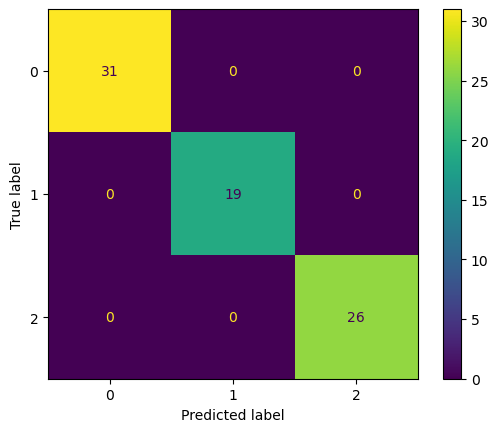

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("🎯 Balanced Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Optional: Visualize confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [126]:
import numpy as np

def simulate_betting(model, X_test, y_test, df_test, confidence_threshold=0.7, stake=100):
    probs = model.predict_proba(X_test)
    preds = model.predict(X_test)

    profit = 0
    confident_bets = 0
    results = []

    for i in range(len(probs)):
        max_prob = np.max(probs[i])
        pred_class = np.argmax(probs[i])
        actual_class = y_test.iloc[i]
        row = df_test.iloc[i]

        if max_prob >= confidence_threshold:
            confident_bets += 1

            # Select the correct odds based on the predicted class
            if pred_class == 0:
                odds = row['B365H']
            elif pred_class == 1:
                odds = row['B365D']
            else:
                odds = row['B365A']

            if pred_class == actual_class:
                win = stake * odds - stake
                profit += win
                results.append(('Win', win))
            else:
                loss = -stake
                profit += loss
                results.append(('Loss', loss))

    # Print summary
    print(f"💼 Total profit: {profit:.2f}")
    print(f"🎯 Confident bets placed: {confident_bets}")
    print(f"📊 Average profit per bet: {profit / confident_bets if confident_bets > 0 else 0:.2f}")
    
    return results

In [127]:
df_test = df_clean.loc[y_test.index].copy()

results = simulate_betting(model, X_test, y_test, df_test, confidence_threshold=0.7)

💼 Total profit: 13323.00
🎯 Confident bets placed: 75
📊 Average profit per bet: 177.64


In [128]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

# Evaluation
print("🌲 Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred, zero_division=0))


🌲 Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        26

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



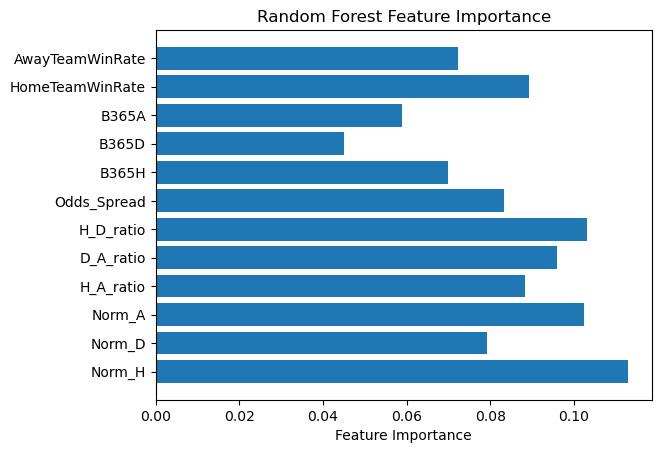

In [59]:
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_
features = X.columns

plt.barh(features, feature_importance)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [18]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 822.3 kB/s eta 0:00:00 kB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [129]:
import xgboost as xgb

# Set up XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # we want class predictions
    num_class=3,                # three possible outcomes: Home, Draw, Away
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=1,         # class balancing handled via sample_weight or during preprocessing
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_pred = xgb_model.predict(X_test)

print("⚡ XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, zero_division=0))


⚡ XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        26

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



/Users/ahmedsaliu/data_sci_sandbox/sample_project/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
